In [1]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage import rotate
import itertools
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import accuracy_score,roc_curve,auc
from PIL import Image
sns.set(style='white', context='notebook', palette='deep')

In [8]:
!gdown --id 1ap5dhuEgpPC5PrJozAu2VFmUNIRZrar2 -O dataset.zip
!unzip dataset.zip -d apddv2_folder

'gdown' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
dataset_path = "./apddv2_folder"

#Check Dataset Size
num_files = sum(len(files) for _, _, files in os.walk(dataset_path))
print(f"Total Files in Dataset: {num_files}")
print("-" * 40)

# Show first 5 files per folder
for root, dirs, files in os.walk(dataset_path):
    print(f"Folder: {root}")
    for file in files[:5]:
        print(f"{file}")
    print("-" * 40)

#Show File Types
file_types = {}
for file in glob.glob(dataset_path + "/**/*", recursive=True):
    ext = os.path.splitext(file)[1]
    file_types[ext] = file_types.get(ext, 0) + 1

print("File Types Summary:")
for ext, count in file_types.items():
    print(f"{ext}: {count} files")

Total Files in Dataset: 10023
----------------------------------------
Folder: ./apddv2_folder
8ab746a16f654eca84badf0886057bed.png
0aa13fdf64674765bbb7c0c4e61df4f3.jpg
0c7c30f31506453086fedc6aef1e0af1.png
dbada7797d244d54b42fd17890c07281.jpg
478489ae477443a09cd5e228f569c2b9.jpg
----------------------------------------
File Types Summary:
.png: 2768 files
.jpg: 7001 files
.JPG: 253 files
.jpeg: 1 files


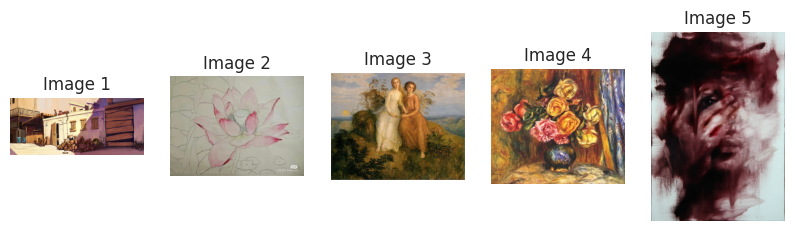

In [10]:
image_files = glob.glob(dataset_path + "/**/*.jpg", recursive=True)[:5]

plt.figure(figsize=(10, 5))
for i, img_path in enumerate(image_files):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image {i+1}")

plt.show()

In [11]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="pandas.io.formats.format")

In [12]:
# Load APDDv2 data
data = pd.read_csv('/kaggle/input/apddv2-csvfiles/APDDv2-10023.csv',encoding='ISO-8859-1')
data.head()

,filename,Artistic Categories,Total aesthetic score,Theme and logic,Creativity,Layout and composition,Space and perspective,The sense of order,Light and shadow,Color,Details and texture,The overall,Mood,Language Comment
0,0000d0cd38984fffb2c04f964edc9c88.png,traditional Chinese painting*meticulous*mounta...,65.83,7.17,NaN,6.00,5.83,6.00,6.17,5.67,6.50,6.50,6.67,The composition of the picture is rigid and la...
1,000ce20bcec24f29815a9496bf314c11.jpg,sketching*classicism*still life,60.71,5.71,NaN,6.71,6.43,5.71,5.71,NaN,5.14,5.86,6.00,"Each side of the picture is good, making it a ..."
2,000d472bde3c4f4c8dc9f66fede4d463.jpg,oil painting*romanticism*landscapes,65.00,6.20,5.6,6.20,NaN,6.80,NaN,6.60,6.40,6.60,6.40,NaN
3,00122f4a71a847a4b076756dbbf7b349.jpg,oil painting*symbolism*still life,82.86,8.29,NaN,8.29,8.57,8.00,8.29,8.29,8.14,8.14,8.57,NaN
4,00148cf2d7134849872279e21131540c.png,traditional Chinese painting*meticulous*mounta...,66.67,7.67,NaN,6.67,7.00,6.67,7.17,7.00,7.00,6.67,6.17,"The composition is full, the details are rich,..."


In [13]:
columns_to_drop = data.columns[[1,3,4,6,7,8,11,12,13]]
data = data.drop(columns=columns_to_drop)
data.head()

,filename,Total aesthetic score,Layout and composition,Color,Details and texture
0,0000d0cd38984fffb2c04f964edc9c88.png,65.83,6.00,5.67,6.50
1,000ce20bcec24f29815a9496bf314c11.jpg,60.71,6.71,NaN,5.14
2,000d472bde3c4f4c8dc9f66fede4d463.jpg,65.00,6.20,6.60,6.40
3,00122f4a71a847a4b076756dbbf7b349.jpg,82.86,8.29,8.29,8.14
4,00148cf2d7134849872279e21131540c.png,66.67,6.67,7.00,7.00


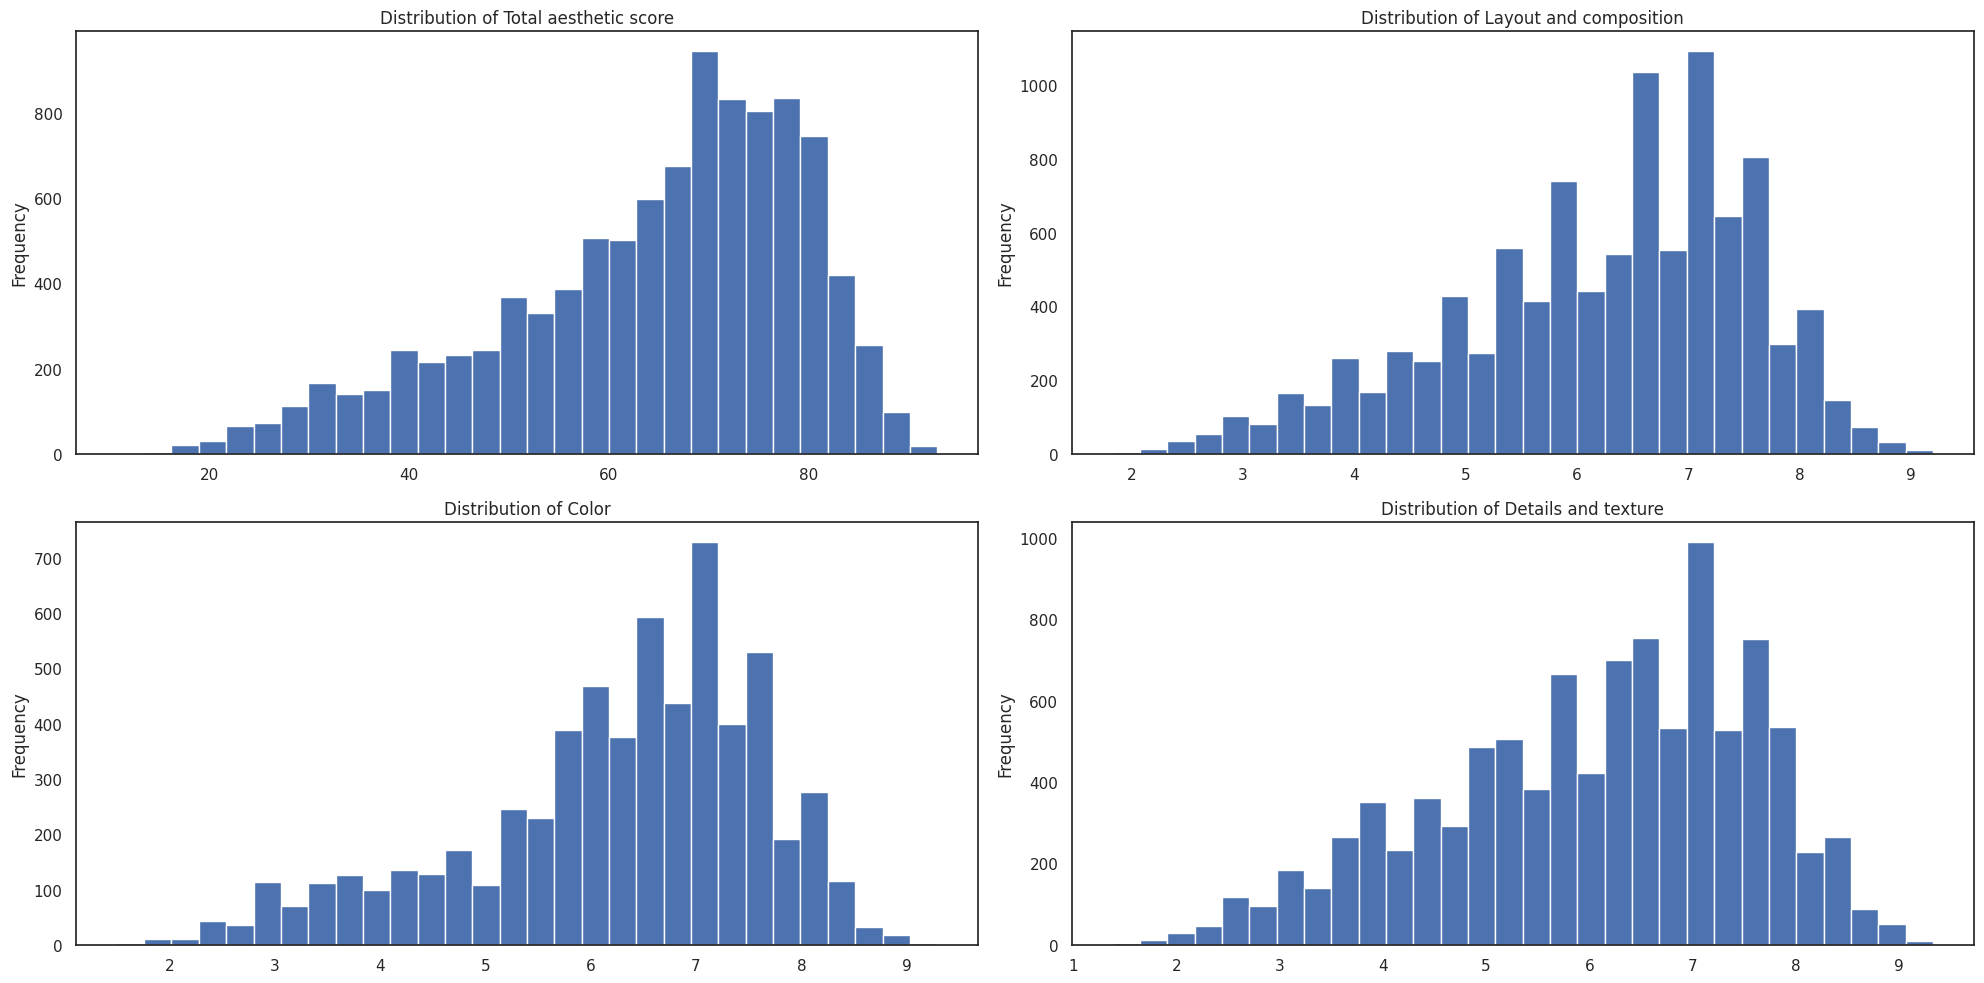

In [14]:
#visualize the distribution of the scores
score_columns = data.columns[1:]
plt.figure(figsize=(20, 10))
for i, col in enumerate(score_columns, 1):
    plt.subplot(2, 2, i)
    data[col].plot(kind='hist', bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

In [15]:
# Check for missing values
print(f"data:\n{data.isnull().sum()}\n")
print("-" * 40)

# Identify invalid filenames
def find_invalid_filenames(dataframe, base_dir):
    invalid_files = []
    for _, row in dataframe.iterrows():
        filename = f"{row['filename']}"
        file_path = os.path.join(base_dir, filename)
        if not os.path.isfile(file_path):
            invalid_files.append(filename)
    return invalid_files

invalid_filenames = find_invalid_filenames(data, dataset_path)
print(f"Number of invalid files: {len(invalid_filenames)}")

data:
filename                     0
Total aesthetic score        0
Layout and composition       0
Color                     3822
Details and texture          0
dtype: int64

----------------------------------------
Number of invalid files: 0


In [16]:
data['has_color'] = data['Color'].notnull().astype(int)

data.head()

,filename,Total aesthetic score,Layout and composition,Color,Details and texture,has_color
0,0000d0cd38984fffb2c04f964edc9c88.png,65.83,6.00,5.67,6.50,1
1,000ce20bcec24f29815a9496bf314c11.jpg,60.71,6.71,NaN,5.14,0
2,000d472bde3c4f4c8dc9f66fede4d463.jpg,65.00,6.20,6.60,6.40,1
3,00122f4a71a847a4b076756dbbf7b349.jpg,82.86,8.29,8.29,8.14,1
4,00148cf2d7134849872279e21131540c.png,66.67,6.67,7.00,7.00,1


In [17]:
data.loc[data['has_color'] == 0, 'Color'] = -1

# Check again for missing values
print(f"data:\n{data.isnull().sum()}\n")
print("-" * 40)
data.head()

data:
filename                  0
Total aesthetic score     0
Layout and composition    0
Color                     0
Details and texture       0
has_color                 0
dtype: int64

----------------------------------------


,filename,Total aesthetic score,Layout and composition,Color,Details and texture,has_color
0,0000d0cd38984fffb2c04f964edc9c88.png,65.83,6.00,5.67,6.50,1
1,000ce20bcec24f29815a9496bf314c11.jpg,60.71,6.71,-1.00,5.14,0
2,000d472bde3c4f4c8dc9f66fede4d463.jpg,65.00,6.20,6.60,6.40,1
3,00122f4a71a847a4b076756dbbf7b349.jpg,82.86,8.29,8.29,8.14,1
4,00148cf2d7134849872279e21131540c.png,66.67,6.67,7.00,7.00,1


In [18]:
class APDDv2Dataset(Dataset):
    def __init__(self, data, dataset_path, attribute, transform=None):
        if isinstance(data, pd.DataFrame):
            self.df = data.copy()  # Directly use the DataFrame
        else:
            raise TypeError(f"Expected a DataFrame, but got {type(data)}")

        self.df.columns = self.df.columns.str.strip()
        self.dataset_path = dataset_path
        self.attribute = attribute
        self.transform = transform

        # Find image column
        self.image_col = next((col for col in ['image_name', 'filename', 'image', 'img_path']
                            if col in self.df.columns), None)
        if not self.image_col:
            raise KeyError("Image column not found in CSV/DataFrame")

        # Store normalization parameters
        self.mean = self.df[attribute].mean()
        self.std = self.df[attribute].std()
        print(f"Label stats - Mean: {self.mean:.2f}, Std: {self.std:.2f}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.dataset_path, row[self.image_col])
        image = Image.open(img_path).convert('RGB')

        # Normalize labels
        label = (row[self.attribute] - self.mean) / self.std

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)



In [19]:
clip_mean = [0.48145466, 0.4578275, 0.40821073]
clip_std = [0.26862954, 0.26130258, 0.27577711]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(clip_mean, clip_std)
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(clip_mean, clip_std)
])

In [20]:
def create_dataloaders(config):
    # Create dataset
    full_dataset = APDDv2Dataset(
        config.csv_path, config.dataset_path, config.attribute, valid_transform
    )

    # Compute mean & std
    all_labels = torch.tensor([sample[1] for sample in full_dataset])
    dataset_mean = all_labels.mean().item()
    dataset_std = all_labels.std().item()

    # Split dataset
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size]
    )

    # Apply train transform
    train_dataset.dataset.transform = train_transform

    # Store dataset and statistics
    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True),
        'valid': DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False),
        'test': DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False),
        'mean': dataset_mean,
        'std': dataset_std,
        'full_dataset': full_dataset
    }

    print("Dataloaders keys:", dataloaders.keys())  # Debugging line
    return dataloaders


In [21]:
torch.cuda.empty_cache()

In [23]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-crv2ldyu
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-crv2ldyu
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=ec9e01740661024c5648003dc9461178ef192eff0f6f57636dcb25e046e730d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-xa1tx6bv/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import torch
import torch.nn as nn
import clip
from PIL import Image
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score , mean_absolute_error
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
model_folder = r"D:\GP\Aes_Scores\Model"
sys.path.append(model_folder)

#  Import AesCLIP_reg from aes_clip.py
try:
    from aes_clip import AesCLIP_reg  
    logger.info(" Successfully imported AesCLIP_reg from aes_clip.py")
except ImportError as e:
    logger.error(f"Error importing AesCLIP_reg: {e}")
    raise

In [26]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import random_split

def train_model(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataloaders = create_dataloaders(config)

    # Ensure AesCLIP_reg is defined
    model = AesCLIP_reg(config.clip_model).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs, eta_min=config.min_lr)
    criterion = nn.HuberLoss(delta=1.0)

    # Retrieve dataset mean & std
    dataset_mean = dataloaders['mean']
    dataset_std = dataloaders['std']

    # Gradient clipping
    max_grad_norm = 1.0

    # Early stopping setup
    best_valid_loss = float('inf')
    patience_counter = 0
    scaler = torch.amp.GradScaler()
    best_pearson = -1

    # Store losses
    train_losses, valid_losses = [], []

    print("\nDataset Split Sizes:")
    print(f"Train: {len(dataloaders['train'].dataset)}")
    print(f"Valid: {len(dataloaders['valid'].dataset)}")
    print(f"Test: {len(dataloaders['test'].dataset)}")

    for epoch in range(config.epochs):
        model.train()
        train_loss = 0.0

        for images, labels in tqdm(dataloaders['train'], desc=f'Epoch {epoch+1}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Use AMP only if CUDA is available
            use_amp = torch.cuda.is_available()
            with torch.amp.autocast('cuda', dtype=torch.float16) if use_amp else torch.amp.autocast('cpu', dtype=torch.float32):
                outputs = model(images).view(-1)  # Ensure shape matches labels
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Unscale and clip gradients
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            train_loss += loss.item() * images.size(0)

        scheduler.step()
        train_loss /= len(dataloaders['train'].dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        valid_loss, all_preds, all_labels = 0.0, [], []

        with torch.no_grad():
            for images, labels in dataloaders['valid']:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).view(-1)  # Ensure shape matches labels

                valid_loss += criterion(outputs, labels).item() * images.size(0)
                all_preds.extend(outputs.cpu().numpy().flatten())  # Flatten before appending
                all_labels.extend(labels.cpu().numpy().flatten())

        valid_loss /= len(dataloaders['valid'].dataset)
        valid_losses.append(valid_loss)

        # Early stopping check
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config.early_stop_patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

        # Convert back to original scale
        all_preds = np.array(all_preds) * dataset_std + dataset_mean
        all_labels = np.array(all_labels) * dataset_std + dataset_mean

        # Compute metrics
        pearson = pearsonr(all_labels, all_preds)[0]
        mae = mean_absolute_error(all_labels, all_preds)
        mse = mean_squared_error(all_labels, all_preds)
        r2 = r2_score(all_labels, all_preds)

        print(f"\n{config.attribute} - Epoch {epoch+1}/{config.epochs}")
        print(f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")
        print(f"Pearson: {pearson:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | R²: {r2:.4f}")

        if pearson > best_pearson:
            best_pearson = pearson
            torch.save(model.state_dict(), config.save_path)
            print(f"New best model saved with Pearson {pearson:.4f}")

    return train_losses, valid_losses




In [27]:
import os

class Config:
    attribute = "Total aesthetic score"
    csv_path = data
    dataset_path = "/content/apddv2_folder"
    batch_size = 64
    epochs = 15
    lr = 1e-4
    weight_decay = 1e-5
    clip_model = "ViT-B/16"

    # Ensure safe file naming
    attribute_safe = "".join(c if c.isalnum() or c in ["_", "-"] else "_" for c in attribute)
    save_path = os.path.join("/content/drive/MyDrive", f"best_{attribute_safe}_model.pth")

    warmup_epochs = 3
    min_lr = 1e-6
    early_stop_patience = 3


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if __name__ == "__main__":
    opt = Config()
    print(f"Starting training for attribute: {opt.attribute}")
    print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

    train_losses, valid_losses = train_model(opt)

Starting training for attribute: Layout and composition
Using device: cuda
Label stats - Mean: 6.22, Std: 1.33
Dataloaders keys: dict_keys(['train', 'valid', 'test', 'mean', 'std', 'full_dataset'])

Dataset Split Sizes:
Train: 7016
Valid: 1503
Test: 1504


Epoch 1: 100%|██████████| 110/110 [04:14<00:00,  2.31s/it]



Layout and composition - Epoch 1/15
Train Loss: 1.0468 | Valid Loss: 0.3627
Pearson: 0.5423 | MAE: 0.7253 | MSE: 0.8278 | R²: 0.1383
New best model saved with Pearson 0.5423


Epoch 2: 100%|██████████| 110/110 [04:14<00:00,  2.32s/it]



Layout and composition - Epoch 2/15
Train Loss: 0.4876 | Valid Loss: 0.3182
Pearson: 0.6082 | MAE: 0.6657 | MSE: 0.7093 | R²: 0.2616
New best model saved with Pearson 0.6082


Epoch 3: 100%|██████████| 110/110 [04:16<00:00,  2.33s/it]



Layout and composition - Epoch 3/15
Train Loss: 0.4373 | Valid Loss: 0.2630
Pearson: 0.6572 | MAE: 0.5934 | MSE: 0.5790 | R²: 0.3973
New best model saved with Pearson 0.6572


Epoch 4: 100%|██████████| 110/110 [04:06<00:00,  2.24s/it]



Layout and composition - Epoch 4/15
Train Loss: 0.4225 | Valid Loss: 0.2371
Pearson: 0.7030 | MAE: 0.5637 | MSE: 0.5111 | R²: 0.4680
New best model saved with Pearson 0.7030


Epoch 5: 100%|██████████| 110/110 [04:03<00:00,  2.21s/it]



Layout and composition - Epoch 5/15
Train Loss: 0.3856 | Valid Loss: 0.2524
Pearson: 0.7007 | MAE: 0.5793 | MSE: 0.5500 | R²: 0.4275


Epoch 6: 100%|██████████| 110/110 [03:57<00:00,  2.16s/it]



Layout and composition - Epoch 6/15
Train Loss: 0.3771 | Valid Loss: 0.2302
Pearson: 0.7201 | MAE: 0.5518 | MSE: 0.4928 | R²: 0.4871
New best model saved with Pearson 0.7201


Epoch 7: 100%|██████████| 110/110 [04:02<00:00,  2.20s/it]



Layout and composition - Epoch 7/15
Train Loss: 0.3618 | Valid Loss: 0.2285
Pearson: 0.7097 | MAE: 0.5461 | MSE: 0.4955 | R²: 0.4842


Epoch 8: 100%|██████████| 110/110 [03:59<00:00,  2.17s/it]



Layout and composition - Epoch 8/15
Train Loss: 0.3601 | Valid Loss: 0.2153
Pearson: 0.7239 | MAE: 0.5332 | MSE: 0.4607 | R²: 0.5205
New best model saved with Pearson 0.7239


Epoch 9: 100%|██████████| 110/110 [04:01<00:00,  2.20s/it]



Layout and composition - Epoch 9/15
Train Loss: 0.3547 | Valid Loss: 0.2180
Pearson: 0.7213 | MAE: 0.5340 | MSE: 0.4683 | R²: 0.5126


Epoch 10: 100%|██████████| 110/110 [03:58<00:00,  2.17s/it]



Layout and composition - Epoch 10/15
Train Loss: 0.3324 | Valid Loss: 0.2063
Pearson: 0.7395 | MAE: 0.5220 | MSE: 0.4410 | R²: 0.5410
New best model saved with Pearson 0.7395


Epoch 11: 100%|██████████| 110/110 [04:01<00:00,  2.19s/it]



Layout and composition - Epoch 11/15
Train Loss: 0.3431 | Valid Loss: 0.2150
Pearson: 0.7289 | MAE: 0.5310 | MSE: 0.4584 | R²: 0.5229


Epoch 12: 100%|██████████| 110/110 [03:57<00:00,  2.16s/it]



Layout and composition - Epoch 12/15
Train Loss: 0.3244 | Valid Loss: 0.2011
Pearson: 0.7508 | MAE: 0.5170 | MSE: 0.4235 | R²: 0.5592
New best model saved with Pearson 0.7508


Epoch 13: 100%|██████████| 110/110 [03:58<00:00,  2.17s/it]



Layout and composition - Epoch 13/15
Train Loss: 0.3244 | Valid Loss: 0.2058
Pearson: 0.7382 | MAE: 0.5141 | MSE: 0.4394 | R²: 0.5426


Epoch 14: 100%|██████████| 110/110 [03:55<00:00,  2.14s/it]



Layout and composition - Epoch 14/15
Train Loss: 0.3218 | Valid Loss: 0.2034
Pearson: 0.7451 | MAE: 0.5168 | MSE: 0.4294 | R²: 0.5530


Epoch 15: 100%|██████████| 110/110 [03:54<00:00,  2.13s/it]



Early stopping at epoch 15


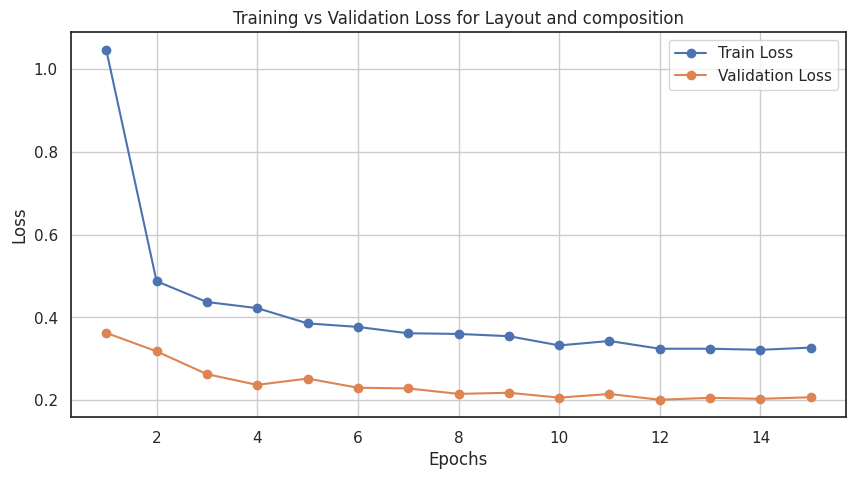

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Training vs Validation Loss for {opt.attribute}")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
if __name__ == "__main__":
    opt = Config()
    print(f"Starting training for attribute: {opt.attribute}")
    print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

    train_losses, valid_losses = train_model(opt)

Starting training for attribute: Details and texture
Using device: cuda
Label stats - Mean: 6.06, Std: 1.51
Dataloaders keys: dict_keys(['train', 'valid', 'test', 'mean', 'std', 'full_dataset'])

Dataset Split Sizes:
Train: 7016
Valid: 1503
Test: 1504


Epoch 1: 100%|██████████| 110/110 [04:12<00:00,  2.30s/it]



Details and texture - Epoch 1/15
Train Loss: 0.9436 | Valid Loss: 0.3116
Pearson: 0.6090 | MAE: 0.6548 | MSE: 0.7041 | R²: 0.2991
New best model saved with Pearson 0.6090


Epoch 2: 100%|██████████| 110/110 [04:20<00:00,  2.37s/it]



Details and texture - Epoch 2/15
Train Loss: 0.4747 | Valid Loss: 0.2799
Pearson: 0.6762 | MAE: 0.6115 | MSE: 0.6224 | R²: 0.3804
New best model saved with Pearson 0.6762


Epoch 3: 100%|██████████| 110/110 [04:09<00:00,  2.26s/it]



Details and texture - Epoch 3/15
Train Loss: 0.4172 | Valid Loss: 0.2373
Pearson: 0.7283 | MAE: 0.5635 | MSE: 0.5110 | R²: 0.4913
New best model saved with Pearson 0.7283


Epoch 4: 100%|██████████| 110/110 [04:06<00:00,  2.24s/it]



Details and texture - Epoch 4/15
Train Loss: 0.3971 | Valid Loss: 0.2327
Pearson: 0.7203 | MAE: 0.5568 | MSE: 0.4969 | R²: 0.5054


Epoch 5: 100%|██████████| 110/110 [04:03<00:00,  2.21s/it]



Details and texture - Epoch 5/15
Train Loss: 0.3767 | Valid Loss: 0.2210
Pearson: 0.7449 | MAE: 0.5468 | MSE: 0.4676 | R²: 0.5346
New best model saved with Pearson 0.7449


Epoch 6: 100%|██████████| 110/110 [04:02<00:00,  2.20s/it]



Details and texture - Epoch 6/15
Train Loss: 0.3578 | Valid Loss: 0.2072
Pearson: 0.7589 | MAE: 0.5207 | MSE: 0.4357 | R²: 0.5662
New best model saved with Pearson 0.7589


Epoch 7: 100%|██████████| 110/110 [04:05<00:00,  2.23s/it]



Details and texture - Epoch 7/15
Train Loss: 0.3528 | Valid Loss: 0.2091
Pearson: 0.7560 | MAE: 0.5229 | MSE: 0.4458 | R²: 0.5562


Epoch 8: 100%|██████████| 110/110 [04:00<00:00,  2.18s/it]



Details and texture - Epoch 8/15
Train Loss: 0.3376 | Valid Loss: 0.2136
Pearson: 0.7567 | MAE: 0.5313 | MSE: 0.4543 | R²: 0.5478


Epoch 9: 100%|██████████| 110/110 [04:01<00:00,  2.20s/it]



Details and texture - Epoch 9/15
Train Loss: 0.3292 | Valid Loss: 0.1878
Pearson: 0.7832 | MAE: 0.4940 | MSE: 0.3914 | R²: 0.6104
New best model saved with Pearson 0.7832


Epoch 10: 100%|██████████| 110/110 [04:03<00:00,  2.21s/it]



Details and texture - Epoch 10/15
Train Loss: 0.3272 | Valid Loss: 0.1913
Pearson: 0.7798 | MAE: 0.4978 | MSE: 0.4020 | R²: 0.5999


Epoch 11: 100%|██████████| 110/110 [03:59<00:00,  2.18s/it]



Details and texture - Epoch 11/15
Train Loss: 0.3146 | Valid Loss: 0.1964
Pearson: 0.7733 | MAE: 0.5036 | MSE: 0.4146 | R²: 0.5873


Epoch 12: 100%|██████████| 110/110 [04:01<00:00,  2.19s/it]



Details and texture - Epoch 12/15
Train Loss: 0.3172 | Valid Loss: 0.1872
Pearson: 0.7814 | MAE: 0.4889 | MSE: 0.3937 | R²: 0.6081


Epoch 13: 100%|██████████| 110/110 [04:01<00:00,  2.20s/it]



Details and texture - Epoch 13/15
Train Loss: 0.3142 | Valid Loss: 0.1893
Pearson: 0.7779 | MAE: 0.4926 | MSE: 0.3979 | R²: 0.6039


Epoch 14: 100%|██████████| 110/110 [03:59<00:00,  2.18s/it]



Details and texture - Epoch 14/15
Train Loss: 0.3079 | Valid Loss: 0.1893
Pearson: 0.7791 | MAE: 0.4962 | MSE: 0.3988 | R²: 0.6030


Epoch 15: 100%|██████████| 110/110 [04:00<00:00,  2.18s/it]



Early stopping at epoch 15


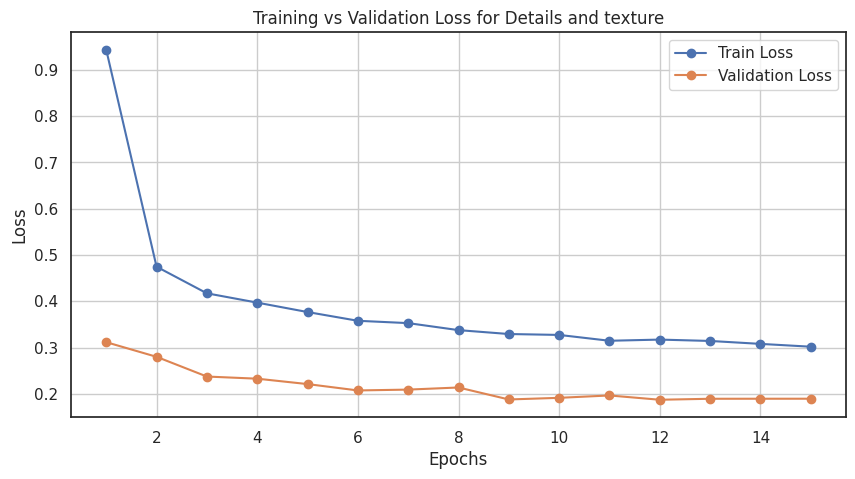

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Training vs Validation Loss for {opt.attribute}")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
if __name__ == "__main__":
    opt = Config()
    print(f"Starting training for attribute: {opt.attribute}")
    print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

    train_losses, valid_losses = train_model(opt)

Starting training for attribute: Color
Using device: cuda
Label stats - Mean: 3.48, Std: 3.69
Dataloaders keys: dict_keys(['train', 'valid', 'test', 'mean', 'std', 'full_dataset'])

Dataset Split Sizes:
Train: 7016
Valid: 1503
Test: 1504


Epoch 1: 100%|██████████| 110/110 [04:16<00:00,  2.33s/it]



Color - Epoch 1/15
Train Loss: 0.8679 | Valid Loss: 0.2210
Pearson: 0.8012 | MAE: 0.5373 | MSE: 0.4708 | R²: 0.5233
New best model saved with Pearson 0.8012


Epoch 2: 100%|██████████| 110/110 [04:12<00:00,  2.30s/it]



Color - Epoch 2/15
Train Loss: 0.3715 | Valid Loss: 0.1553
Pearson: 0.8328 | MAE: 0.4464 | MSE: 0.3216 | R²: 0.6744
New best model saved with Pearson 0.8328


Epoch 3: 100%|██████████| 110/110 [04:18<00:00,  2.35s/it]



Color - Epoch 3/15
Train Loss: 0.3206 | Valid Loss: 0.1177
Pearson: 0.8743 | MAE: 0.3805 | MSE: 0.2410 | R²: 0.7559
New best model saved with Pearson 0.8743


Epoch 4: 100%|██████████| 110/110 [04:21<00:00,  2.38s/it]



Color - Epoch 4/15
Train Loss: 0.2915 | Valid Loss: 0.1059
Pearson: 0.8845 | MAE: 0.3593 | MSE: 0.2170 | R²: 0.7803
New best model saved with Pearson 0.8845


Epoch 5: 100%|██████████| 110/110 [04:16<00:00,  2.33s/it]



Color - Epoch 5/15
Train Loss: 0.2800 | Valid Loss: 0.1037
Pearson: 0.8904 | MAE: 0.3549 | MSE: 0.2127 | R²: 0.7847
New best model saved with Pearson 0.8904


Epoch 6: 100%|██████████| 110/110 [04:14<00:00,  2.32s/it]



Color - Epoch 6/15
Train Loss: 0.2570 | Valid Loss: 0.0970
Pearson: 0.8966 | MAE: 0.3428 | MSE: 0.1980 | R²: 0.7995
New best model saved with Pearson 0.8966


Epoch 7: 100%|██████████| 110/110 [04:09<00:00,  2.27s/it]



Color - Epoch 7/15
Train Loss: 0.2473 | Valid Loss: 0.0907
Pearson: 0.9068 | MAE: 0.3282 | MSE: 0.1858 | R²: 0.8119
New best model saved with Pearson 0.9068


Epoch 8: 100%|██████████| 110/110 [04:07<00:00,  2.25s/it]



Color - Epoch 8/15
Train Loss: 0.2375 | Valid Loss: 0.0863
Pearson: 0.9077 | MAE: 0.3176 | MSE: 0.1763 | R²: 0.8215
New best model saved with Pearson 0.9077


Epoch 9: 100%|██████████| 110/110 [04:09<00:00,  2.26s/it]



Color - Epoch 9/15
Train Loss: 0.2189 | Valid Loss: 0.0787
Pearson: 0.9152 | MAE: 0.3016 | MSE: 0.1605 | R²: 0.8375
New best model saved with Pearson 0.9152


Epoch 10: 100%|██████████| 110/110 [04:06<00:00,  2.24s/it]



Color - Epoch 10/15
Train Loss: 0.2167 | Valid Loss: 0.0741
Pearson: 0.9202 | MAE: 0.2900 | MSE: 0.1519 | R²: 0.8462
New best model saved with Pearson 0.9202


Epoch 11: 100%|██████████| 110/110 [04:09<00:00,  2.27s/it]



Color - Epoch 11/15
Train Loss: 0.2081 | Valid Loss: 0.0763
Pearson: 0.9210 | MAE: 0.2931 | MSE: 0.1561 | R²: 0.8419
New best model saved with Pearson 0.9210


Epoch 12: 100%|██████████| 110/110 [04:10<00:00,  2.28s/it]



Color - Epoch 12/15
Train Loss: 0.2087 | Valid Loss: 0.0749
Pearson: 0.9194 | MAE: 0.2912 | MSE: 0.1537 | R²: 0.8444


Epoch 13: 100%|██████████| 110/110 [04:05<00:00,  2.23s/it]



Early stopping at epoch 13


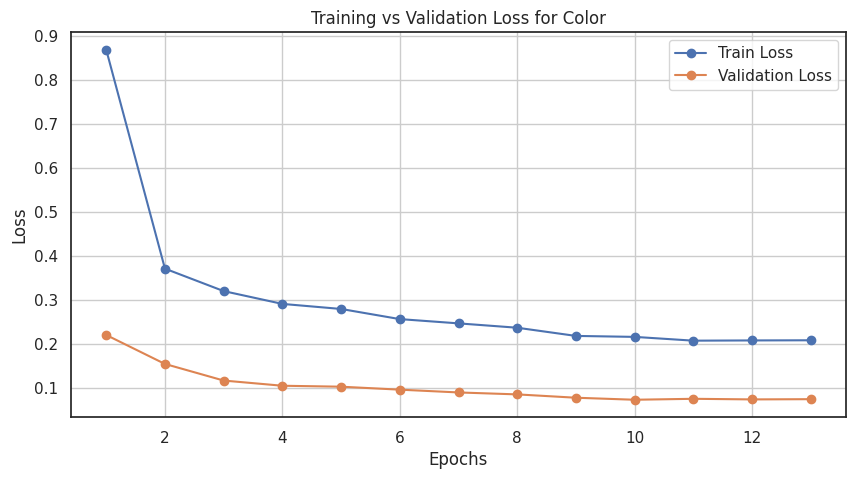

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Training vs Validation Loss for {opt.attribute}")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
if __name__ == "__main__":
    opt = Config()
    print(f"Starting training for attribute: {opt.attribute}")
    print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

    train_losses, valid_losses = train_model(opt)

Starting training for attribute: Total aesthetic score
Using device: cuda
Label stats - Mean: 64.28, Std: 15.24
Dataloaders keys: dict_keys(['train', 'valid', 'test', 'mean', 'std', 'full_dataset'])

Dataset Split Sizes:
Train: 7016
Valid: 1503
Test: 1504


Epoch 1: 100%|██████████| 110/110 [04:15<00:00,  2.32s/it]



Total aesthetic score - Epoch 1/15
Train Loss: 1.0284 | Valid Loss: 0.3413
Pearson: 0.5719 | MAE: 0.6924 | MSE: 0.7810 | R²: 0.2103
New best model saved with Pearson 0.5719


Epoch 2: 100%|██████████| 110/110 [04:13<00:00,  2.31s/it]



Total aesthetic score - Epoch 2/15
Train Loss: 0.4615 | Valid Loss: 0.2668
Pearson: 0.6749 | MAE: 0.6044 | MSE: 0.5811 | R²: 0.4124
New best model saved with Pearson 0.6749


Epoch 3: 100%|██████████| 110/110 [04:08<00:00,  2.26s/it]



Total aesthetic score - Epoch 3/15
Train Loss: 0.4142 | Valid Loss: 0.2436
Pearson: 0.7086 | MAE: 0.5708 | MSE: 0.5288 | R²: 0.4652
New best model saved with Pearson 0.7086


Epoch 4: 100%|██████████| 110/110 [04:07<00:00,  2.25s/it]



Total aesthetic score - Epoch 4/15
Train Loss: 0.3670 | Valid Loss: 0.2341
Pearson: 0.7034 | MAE: 0.5584 | MSE: 0.5064 | R²: 0.4879


Epoch 5: 100%|██████████| 110/110 [04:05<00:00,  2.23s/it]



Total aesthetic score - Epoch 5/15
Train Loss: 0.3620 | Valid Loss: 0.2232
Pearson: 0.7214 | MAE: 0.5401 | MSE: 0.4789 | R²: 0.5157
New best model saved with Pearson 0.7214


Epoch 6: 100%|██████████| 110/110 [04:07<00:00,  2.25s/it]



Total aesthetic score - Epoch 6/15
Train Loss: 0.3495 | Valid Loss: 0.2008
Pearson: 0.7578 | MAE: 0.5145 | MSE: 0.4278 | R²: 0.5674
New best model saved with Pearson 0.7578


Epoch 7: 100%|██████████| 110/110 [04:05<00:00,  2.23s/it]



Total aesthetic score - Epoch 7/15
Train Loss: 0.3386 | Valid Loss: 0.1955
Pearson: 0.7633 | MAE: 0.5030 | MSE: 0.4150 | R²: 0.5803
New best model saved with Pearson 0.7633


Epoch 8: 100%|██████████| 110/110 [04:05<00:00,  2.23s/it]



Total aesthetic score - Epoch 8/15
Train Loss: 0.3189 | Valid Loss: 0.1901
Pearson: 0.7698 | MAE: 0.4966 | MSE: 0.4051 | R²: 0.5904
New best model saved with Pearson 0.7698


Epoch 9: 100%|██████████| 110/110 [04:07<00:00,  2.25s/it]



Total aesthetic score - Epoch 9/15
Train Loss: 0.3144 | Valid Loss: 0.1894
Pearson: 0.7717 | MAE: 0.4966 | MSE: 0.4002 | R²: 0.5953
New best model saved with Pearson 0.7717


Epoch 10: 100%|██████████| 110/110 [04:11<00:00,  2.28s/it]



Total aesthetic score - Epoch 10/15
Train Loss: 0.2977 | Valid Loss: 0.1997
Pearson: 0.7739 | MAE: 0.5048 | MSE: 0.4294 | R²: 0.5658
New best model saved with Pearson 0.7739


Epoch 11: 100%|██████████| 110/110 [04:09<00:00,  2.26s/it]



Total aesthetic score - Epoch 11/15
Train Loss: 0.3005 | Valid Loss: 0.1859
Pearson: 0.7756 | MAE: 0.4915 | MSE: 0.3943 | R²: 0.6013
New best model saved with Pearson 0.7756


Epoch 12: 100%|██████████| 110/110 [04:08<00:00,  2.26s/it]



Total aesthetic score - Epoch 12/15
Train Loss: 0.3013 | Valid Loss: 0.1889
Pearson: 0.7748 | MAE: 0.4934 | MSE: 0.3995 | R²: 0.5960


Epoch 13: 100%|██████████| 110/110 [04:06<00:00,  2.24s/it]



Total aesthetic score - Epoch 13/15
Train Loss: 0.2972 | Valid Loss: 0.1877
Pearson: 0.7763 | MAE: 0.4938 | MSE: 0.3939 | R²: 0.6017
New best model saved with Pearson 0.7763


Epoch 14: 100%|██████████| 110/110 [04:07<00:00,  2.25s/it]



Total aesthetic score - Epoch 14/15
Train Loss: 0.2999 | Valid Loss: 0.1816
Pearson: 0.7846 | MAE: 0.4834 | MSE: 0.3810 | R²: 0.6147
New best model saved with Pearson 0.7846


Epoch 15: 100%|██████████| 110/110 [04:07<00:00,  2.25s/it]



Total aesthetic score - Epoch 15/15
Train Loss: 0.2844 | Valid Loss: 0.1831
Pearson: 0.7793 | MAE: 0.4834 | MSE: 0.3905 | R²: 0.6051


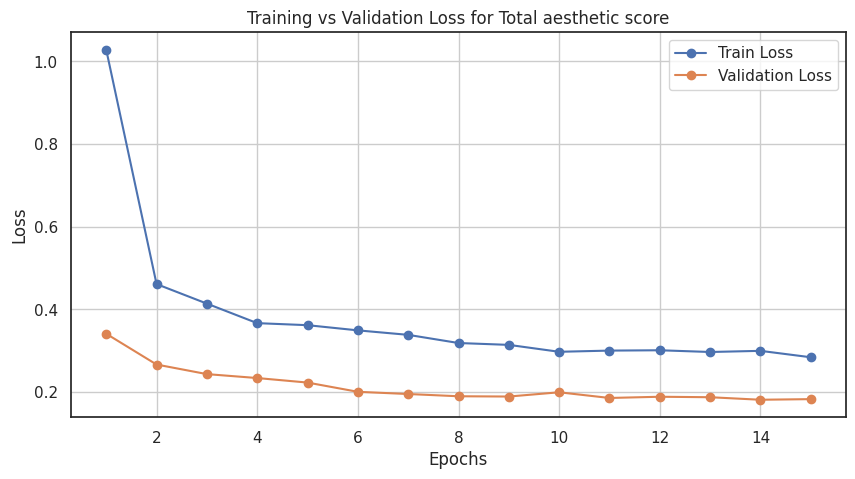

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Training vs Validation Loss for {opt.attribute}")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import torch
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_test_set(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataloaders = create_dataloaders(config)
    full_dataset = dataloaders['full_dataset']
    dataset_mean = dataloaders['mean']
    dataset_std = dataloaders['std']
    model = AesCLIP_reg(config.clip_model).to(device)
    model.load_state_dict(torch.load(config.save_path))
    model.eval()

    test_preds, test_labels = [], []

    with torch.no_grad():
        for images, labels in dataloaders['test']:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)
            outputs = model(images).view(-1)  # Ensure correct shape

            test_preds.extend(outputs.cpu().numpy().astype(np.float32))
            test_labels.extend(labels.cpu().numpy().astype(np.float32))

    # Convert lists to NumPy arrays
    test_preds = np.array(test_preds)
    test_labels = np.array(test_labels)

    # Denormalize
    test_preds = test_preds *  dataset_std +dataset_mean
    test_labels = test_labels * dataset_std + dataset_mean

    # Calculate metrics
    pearson = pearsonr(test_labels, test_preds)[0]
    mae = mean_absolute_error(test_labels, test_preds)
    mse = mean_squared_error(test_labels, test_preds)
    r2 = r2_score(test_labels, test_preds)

    # Print results
    print(f"\nFinal Test Results for {config.attribute}:")
    print(f"Pearson: {pearson:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")

    return {
        "pearson": pearson,
        "mae": mae,
        "mse": mse,
        "r2": r2
    }


In [19]:
test_metrics = evaluate_test_set(opt)

Label stats - Mean: 3.48, Std: 3.69
Dataloaders keys: dict_keys(['train', 'valid', 'test', 'mean', 'std', 'full_dataset'])


<ipython-input-18-cef82eeb1a75>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config.save_path))



Final Test Results for Color:
Pearson: 0.9250
MAE: 0.2781
MSE: 0.1451
R²: 0.8527


In [ ]:
test_metrics = evaluate_test_set(opt)

Label stats - Mean: 6.06, Std: 1.51
Dataloaders keys: dict_keys(['train', 'valid', 'test', 'mean', 'std', 'full_dataset'])


<ipython-input-21-cef82eeb1a75>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config.save_path))



Final Test Results for Details and texture:
Pearson: 0.7912
MAE: 0.4802
MSE: 0.3782
R²: 0.6255


In [23]:
test_metrics = evaluate_test_set(opt)

Label stats - Mean: 64.28, Std: 15.24
Dataloaders keys: dict_keys(['train', 'valid', 'test', 'mean', 'std', 'full_dataset'])


<ipython-input-18-cef82eeb1a75>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config.save_path))



Final Test Results for Total aesthetic score:
Pearson: 0.7898
MAE: 0.4593
MSE: 0.3474
R²: 0.6232


In [4]:
import clip
model, preprocess = clip.load("ViT-B/16", download_root="C:/Users/sara mahmoud/.cache/clip")

  3%|█                                   | 10.3M/335M [12:29<6:34:49, 14.4kiB/s]


RuntimeError: Model has been downloaded but the SHA256 checksum does not not match